<div class="alert alert-info">
<h1>Imputation</h1>
<h4>Environmental Statistics 6</h4>
I.E. Azuh/C.F. Dormann
</div>

Today's session dives into the critical topic of missing data imputation, focusing on two key learning objectives. First, we'll explore why imputation is invaluable in data analysis, highlighting its essential role in preserving sample size and statistical power while reducing bias. Second, we'll delve into the nuances of imputation, emphasizing the importance of careful application. Participants will gain insights into common challenges and pitfalls associated with imputation methods, such as the potential for introducing bias or inaccuracies. Through practical examples and discussions, attendees will learn best practices for navigating these complexities and making informed decisions when imputing missing data. By the end of the session, participants will be equipped with the knowledge and skills needed to effectively utilize imputation techniques in their own research or analytical endeavors.

There are two things to learn today:
-  Why imputation is (very) useful.
-  That imputation requires some care in application.


In [2]:
# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import missingno as msno
import arviz as az
from sklearn.linear_model import BayesianRidge, LinearRegression
from statsmodels.imputation.mice import MICEData, MICE #Predictive Average Matching (PMM) 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.neighbors import KNeighborsRegressor as pmm

import warnings

# 1  Exercise 1:  Diagnose missing data
Load the `pima` data set from `faraway`and represent/visualise missingness.

In [3]:
# load data
pima = pd.read_csv("pima.csv")
pima.describe()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Hm. There are several people with 0 glucose, 0 diastolic blood pressure, 0 insulin, 0 triceps and 0 bmi: that means they are dead. Or, rather, that the 0s here `should be NAs!`. So let’s convert them to 0s to NAs accordingly and look at the data again:

In [4]:
# Replace 0 values in the 'glucose','diastolic', 'triceps', 'insulin' and 'bmi' columns with NaN
pima['glucose'] = pima['glucose'].replace(0, float('nan'))
pima['diastolic'] = pima['diastolic'].replace(0, float('nan'))
pima['triceps'] = pima['triceps'].replace(0, float('nan'))
pima['insulin'] = pima['insulin'].replace(0, float('nan'))
pima['bmi'] = pima['bmi'].replace(0, float('nan'))

pima.describe()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
# shorter code:
columns_to_impute = ['glucose', 'diastolic', 'triceps', 'insulin', 'bmi']
pima[columns_to_impute] = pima[columns_to_impute].replace(0, np.nan)

pima.describe()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 1.1    Quantify missingness
There is a substantial amount of missingness in triceps and insulin. Let’s see how many data points we lose by ‘listwise deletion’:

In [6]:
pima.shape

(768, 9)

In [7]:
pima.dropna().shape

(392, 9)

We’d lose about half of the data!

### 1.2    Visualise missingness
There are two packages that deals with visualising missingness: `seaborn heatmap` and `missingno`. <br>
Here we use the `seaborn heatmap`. For `seaborn heatmap`, you have to create a DataFrame that shows which values are missing in your original DataFrame. This will create a DataFrame where True indicates a missing value and False indicates a non-missing value. Then the `seaborn.heatmap()` function will be applied on the derived dataframe.

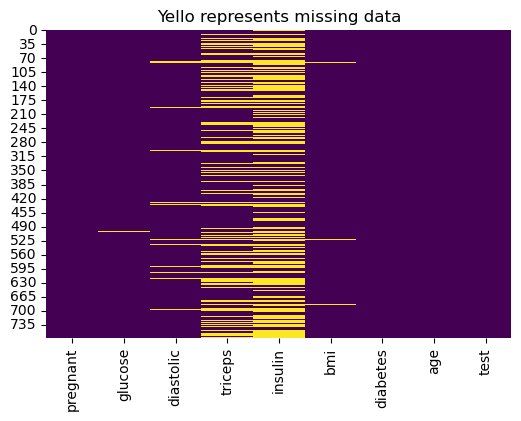

In [8]:
# 1. Using seaborn heatmap

# Create a DataFrame indicating missing values
missing_data_df = pima.isnull()

plt.figure(figsize=(6, 4))  # Set the figure size
sns.heatmap(missing_data_df, cbar=False, cmap='viridis')

plt.title("Yello represents missing data")
plt.show()


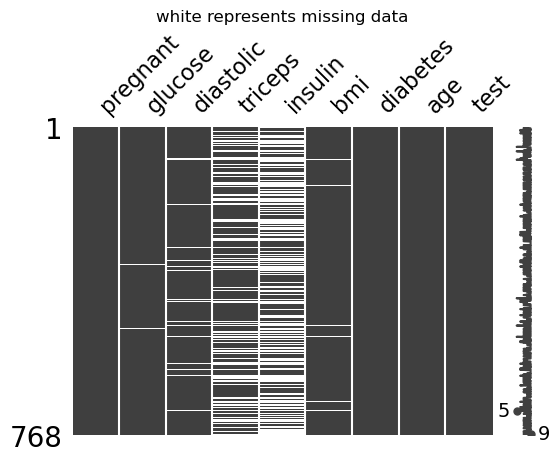

In [9]:
# 2. Using missignno

msno.matrix(pima, figsize=(6,4))
plt.title("white represents missing data")
plt.show()

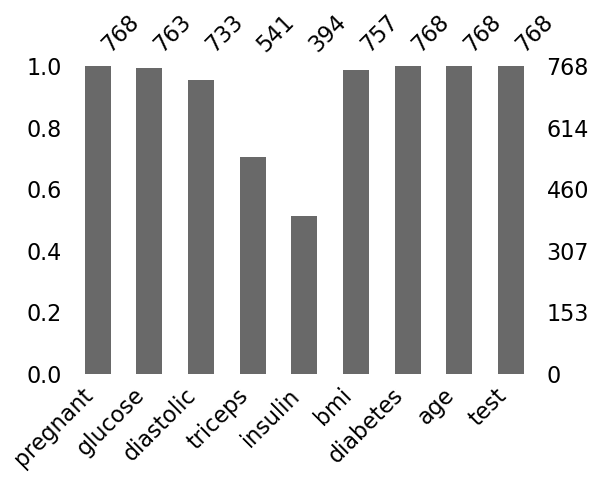

In [10]:
# 3. Using missignno as bar

msno.bar(pima, figsize=(6,4))
plt.show()


# 2  Exercise 2:   Impute in different ways
Generate two different data sets, using the **IterativeImputer(MICE)** and **KNNImputer** function from the `Sklearn` library. Compare the resulting interpolations for predictor `insulin` by correlation.

### 2.1    Using IterativeImputer (MICE)
`IterativeImputer` started its life as a `fancyimpute` originally, but was then merged into `scikit-learn` and deleted from `fancyimpute` in favor of the better-tested `sklearn version`. <br>

It uses multiple imputation by chained equations (MICE) to perform multiple regression over random sample of the data, take average of the multiple regression values and impute the missing feature value for that data point in the datasets. Simply put, it uses a regression techniques to estimate the missing values. The default estimator is `BayesianRidge() → regularised linear regression`. Other estimators includes: `DecisionTreeRegressor → non linear regression`, `ExtraTreesRegressor → for random forest trees` and `KNeighborsRegressos → KNN`.  This method is computationally intensive, so can be slow for very large dataset. In `IterativeImputer`, the process is performed in a single chain which means that it does not directly support multiple imputation with multiple chains. **We have to check for convergence (Rhat values close to 1)**.

In [11]:
# 2.1 IterativeImputer

# Create an iterative imputer
sklearn_imputer = IterativeImputer(random_state=0, n_nearest_features=4) 
                           # estimator = ['BayesianRidge(Default:strategy='mean')' 
                           #'DecisionTreeRegressor()','ExtraTreesRegressor()',
                           #'KNeighborsRegressor()']
                                                                        
# Perform imputation
X_imputed = sklearn_imputer.fit_transform(pima)

# Convert back to a DataFrame (if needed)
MICE_mean_sk_df = pd.DataFrame(data=X_imputed, columns=pima.columns)
MICE_mean_sk_df.describe()

C:\Users\Ikedichi_Azuh\anaconda3\envs\envstats2\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.663656,72.359072,29.407875,153.337145,32.441796,0.471876,33.240885,0.348958
std,3.369578,30.487305,12.122565,8.942714,97.140790,6.882002,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,-17.243189,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,25.000000,90.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,30.000000,133.397632,32.150000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,33.565551,190.050467,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Deriving the means for 4-chain imputations and its Rhat values

In [12]:
# Deriving the means for 4-chain imputations and its Rhat values

pima_subset = pima[['pregnant', 'diastolic', 'triceps', 'bmi','age','insulin']]
np.random.seed(123)
n_iter = 30
n_chains = 4
imputations = []

for _ in range(n_chains):
    imputer = IterativeImputer(max_iter=n_iter, random_state=123)
    imputed_data = imputer.fit_transform(pima_subset)
    imputations.append(pd.DataFrame(imputed_data, columns=pima_subset.columns))


# Calculate mean
print('Mean for n_iter = 30\n')
variable_names = imputations[0].columns

for chain, imputation in enumerate(imputations):
    print(f"Chain {chain + 1}:\n")
    for variable, mean_value in zip(variable_names, np.mean(imputation.values, axis=0)):
        print(f"{variable}: {mean_value:.3f}")
    print("\n")

    
# Calculate R-hat (per column/variable)
rhat_values = {}
for column in pima_subset.columns:
    column_data = np.vstack([imputation[column] for imputation in imputations])
    rhat = az.rhat(column_data)
    rhat_values[column] = rhat

print('Rhat for n_iter = 30\n')
for variable, rhat in rhat_values.items():
    print(f"{variable}: {rhat}")


Mean for n_iter = 30

Chain 1:

pregnant: 3.845
diastolic: 72.360
triceps: 28.921
bmi: 32.455
age: 33.241
insulin: 158.828


Chain 2:

pregnant: 3.845
diastolic: 72.360
triceps: 28.921
bmi: 32.455
age: 33.241
insulin: 158.828


Chain 3:

pregnant: 3.845
diastolic: 72.360
triceps: 28.921
bmi: 32.455
age: 33.241
insulin: 158.828


Chain 4:

pregnant: 3.845
diastolic: 72.360
triceps: 28.921
bmi: 32.455
age: 33.241
insulin: 158.828


Rhat for n_iter = 30

pregnant: 0.9997574817665434
diastolic: 0.9987817936041438
triceps: 0.9989297186724575
bmi: 0.9992295563720899
age: 0.9997625598235143
insulin: 0.9989237562331789


**Please increase the number of iterations if the Rhat values are far from 1**

Let's visualise the chains:


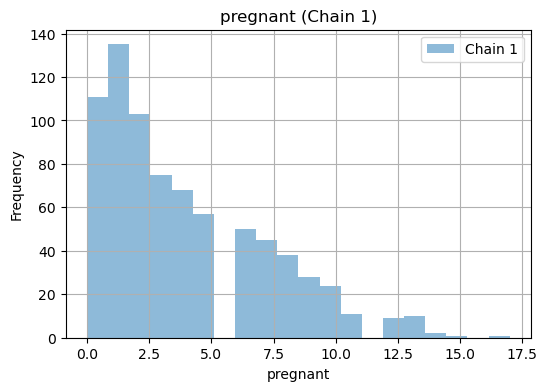

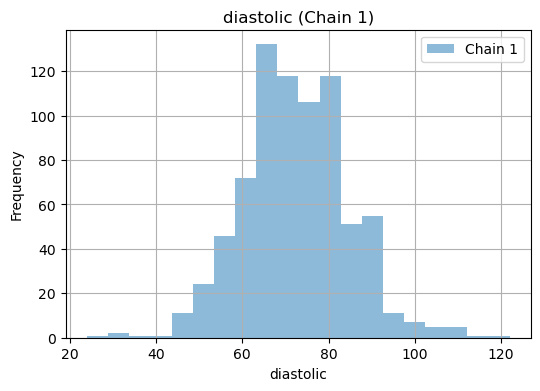

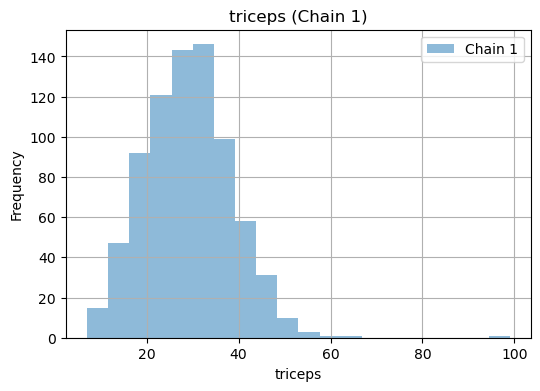

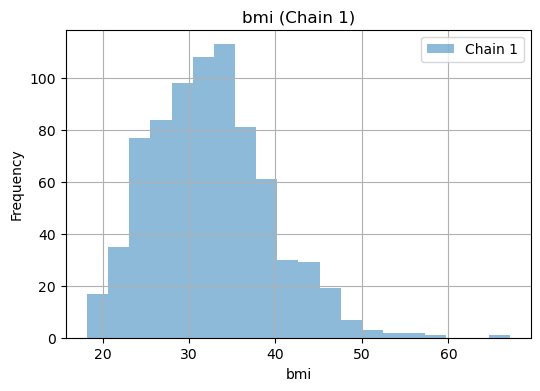

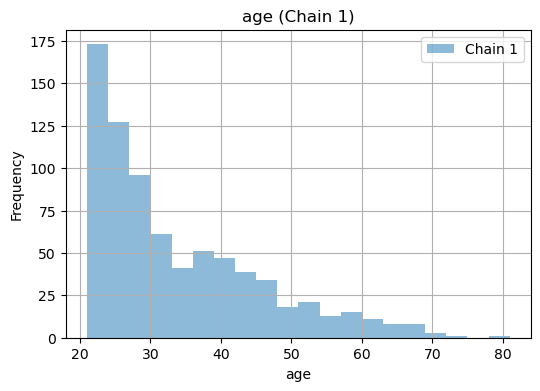

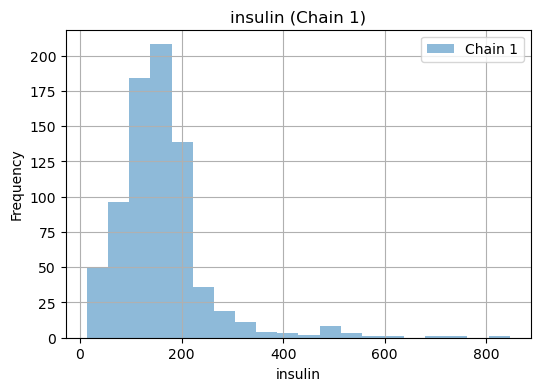

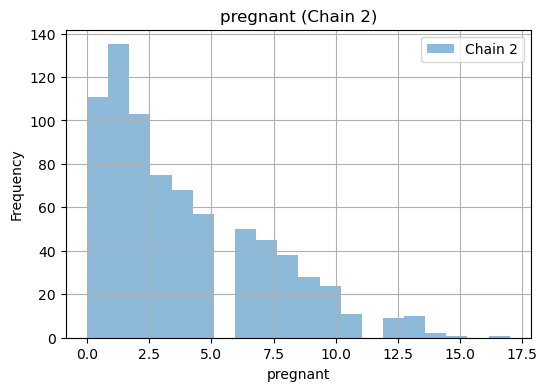

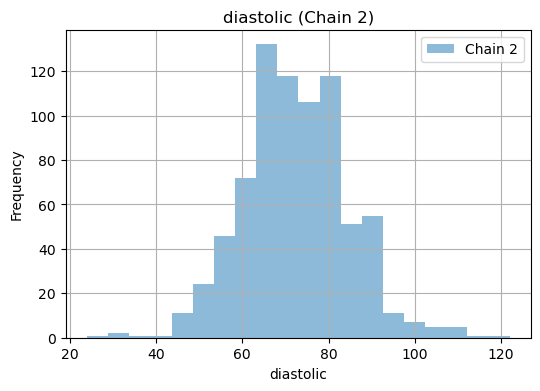

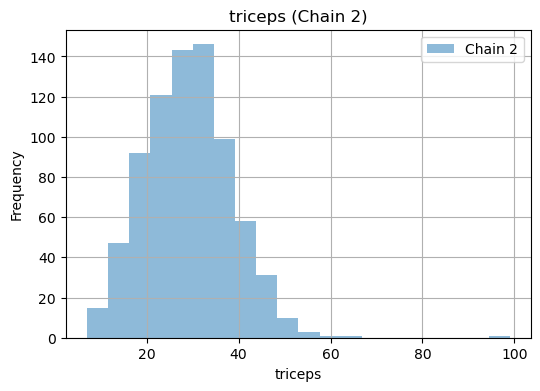

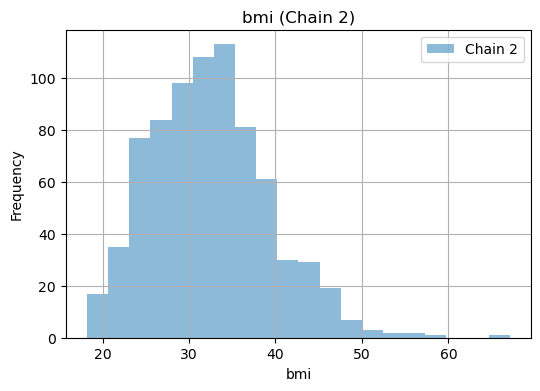

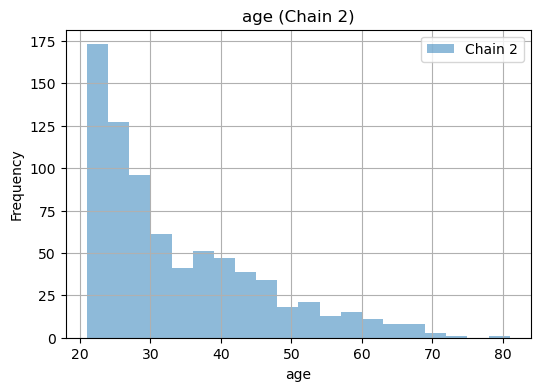

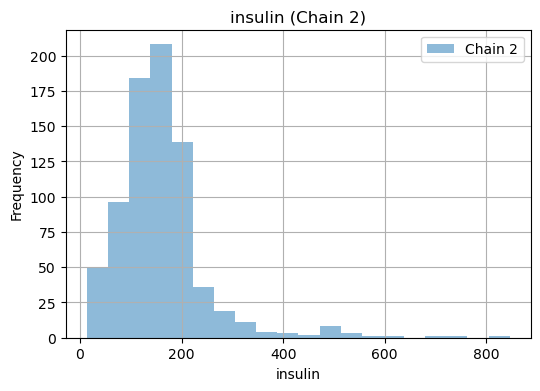

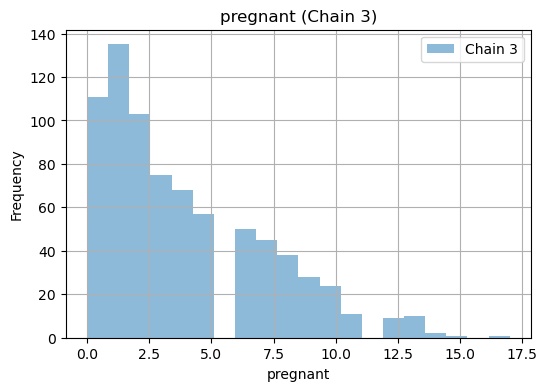

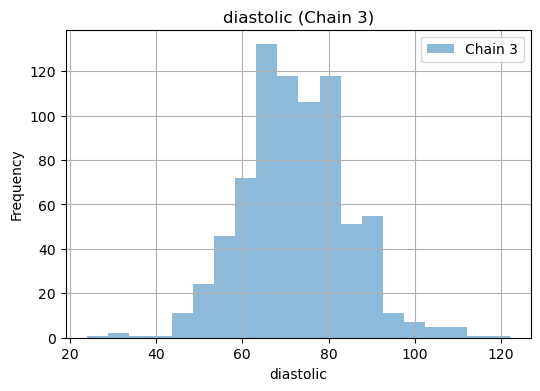

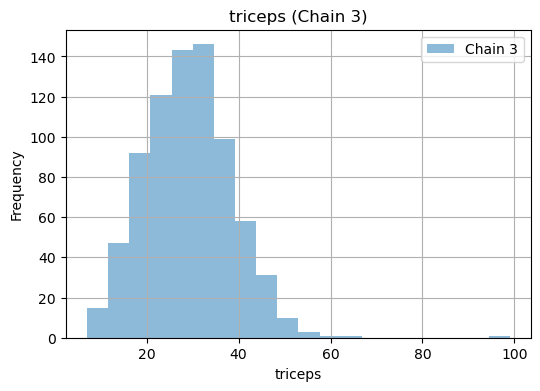

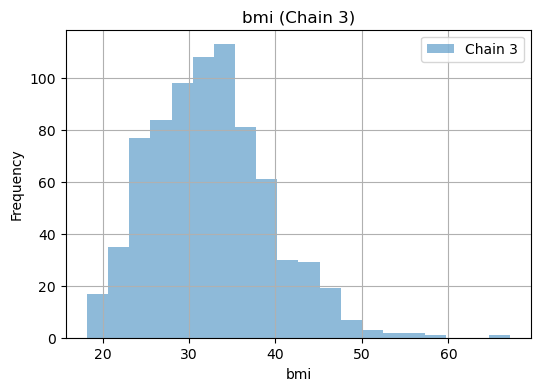

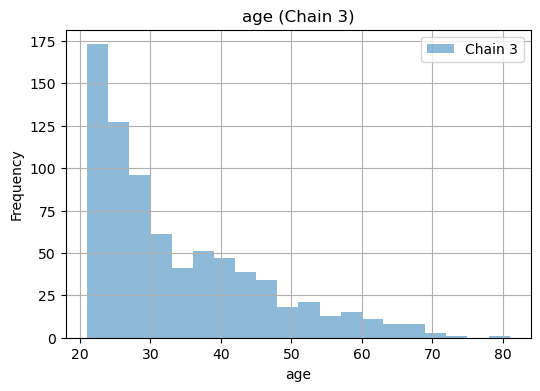

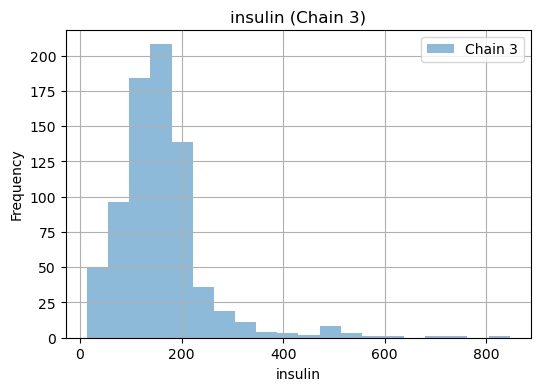

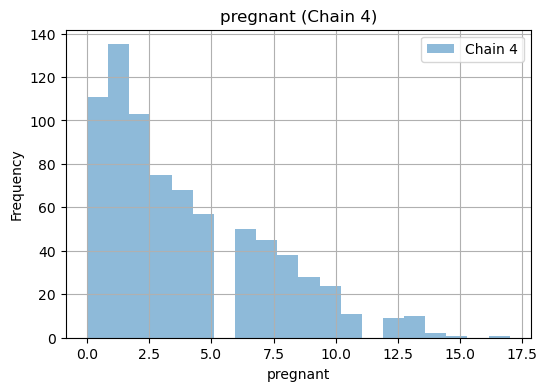

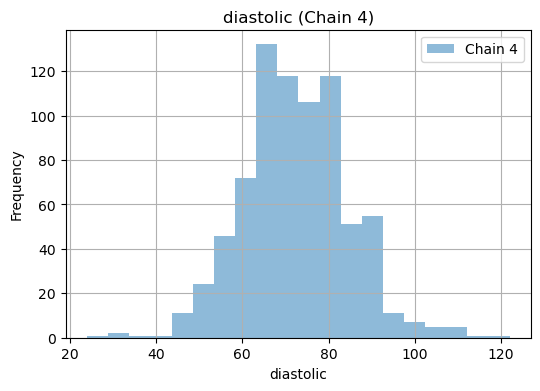

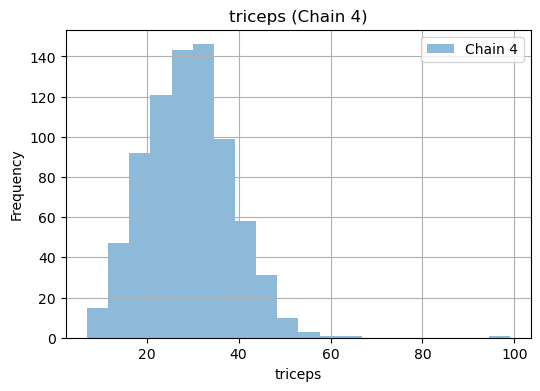

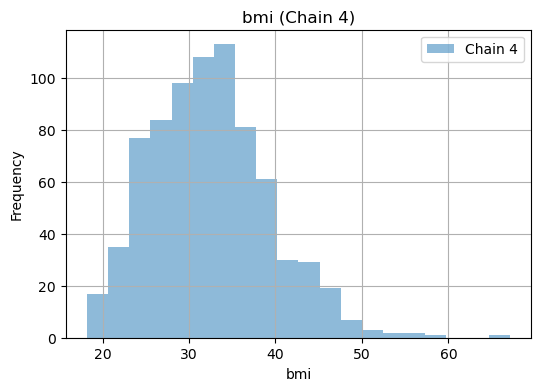

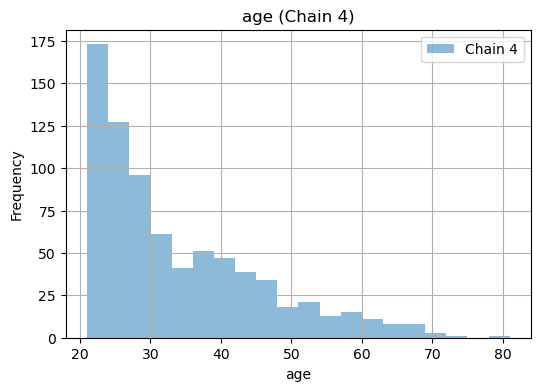

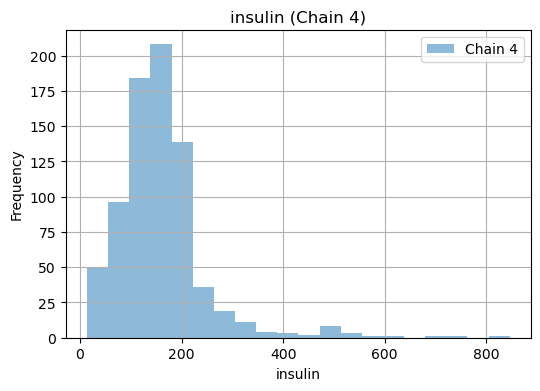

In [13]:
num_bins = 20

for chain, imputation in enumerate(imputations):
    for variable in variable_names:
        plt.figure(figsize=(6, 4))
        plt.hist(imputation[variable], bins=num_bins, alpha=0.5, label=f"Chain {chain + 1}")
        plt.title(f"{variable} (Chain {chain + 1})")
        plt.xlabel(variable)
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.show()

For comparison, we if need a single-imputation file resulting from these imputations, we can :

In [14]:
completed_datasets = [imputation.ffill().bfill() for imputation in imputations]
imput_mi_one = pd.concat(completed_datasets).groupby(level=0).mean()
imput_mi_one['test'] = pima['test']
imput_mi_one['glucose'] = pima['glucose']
imput_mi_one['diabetes'] = pima['diabetes']
imput_mi_one = imput_mi_one[pima.columns.tolist()]
imput_mi_one.describe()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
count,768.000000,763.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.360219,28.920786,158.828439,32.455394,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.141458,9.523828,88.852173,6.877289,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,110.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.382714,147.210640,32.371539,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,35.000000,188.206634,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**BONUS:** We can also use the `MICEData` function from `statsmodels.imputation.mice` library for imputation. Here the predictive average matching (PMM) is used.

In [15]:
## With mice (k_pmm: number of nearest neighbors to use during predictive mean matching. Can also be specified in fit.)
imputer = MICEData(data=pima, perturbation_method='gaussian', k_pmm=2) #'gaussian','boot'

# Fit the MICE imputer
imputer.update_all()

# Access the imputed dataset
imputed_data = imputer.data

imputed_data.head(10)


,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
0,6,148.0,72.0,35.0,193.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,55.0,26.6,0.351,31,0
2,8,183.0,64.0,20.0,680.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,24.0,78.0,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,54.0,30.0,74.0,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,33.0,135.0,37.4,0.232,54,1


### 2.2    Using KNNImputer
The "K" nearest neighbour (KNN) is the most simple imputation technique. It finds the "K" closest neighbours to a given missing data point and imputs missing values based on  the average the "K" neighbours. This method is more effective when the amount of missing data is small. Can be called as `KNNImputer` from the `Sklearn.impute` library. 

In [16]:
#  KNNImputer

# Create an iterative imputer
sklearn_imputer2 = KNNImputer(n_neighbors=2) #metric='nan_euclidean'

# Perform imputation
X_imputed = sklearn_imputer2.fit_transform(pima)

# Convert back to a DataFrame (if needed)
KNN_df = pd.DataFrame(data=X_imputed, columns=pima.columns)
KNN_df.describe()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.585938,72.351562,29.136719,154.897786,32.433464,0.471876,33.240885,0.348958
std,3.369578,30.561687,12.283753,9.774654,105.105784,6.894955,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,84.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,129.000000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,193.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**With MICE a range of different imputation options are available. Please use two different ones and compare imputation by correlation with original and the mi-imputed data: mean replacement (really silly) and predictive mean matching (pmm)**.

In [17]:
## 1. RandomForest 

# Create an instance of the IterativeImputer with the Random Forest method

imputer_rf = IterativeImputer(estimator=rf(n_estimators=100, max_depth=5), n_nearest_features=5)

# Perform multiple imputations
imputed_data_rf = imputer_rf.fit_transform(pima)

# Convert back to a DataFrame (if needed)
RF_df = pd.DataFrame(data=imputed_data_rf, columns=pima.columns)
RF_df.describe()

C:\Users\Ikedichi_Azuh\anaconda3\envs\envstats2\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.720713,72.353057,28.684316,156.439187,32.439623,0.471876,33.240885,0.348958
std,3.369578,30.553146,12.175377,9.630706,101.127770,6.884516,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,89.602248,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,132.400671,32.050000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,35.000000,195.674105,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [18]:
# 2. Predictive Mean Matching (PMM) 

# Create an instance of the IterativeImputer with the PMM method
imputer_pmm = IterativeImputer(estimator=pmm(), n_nearest_features=5)

# Perform multiple imputations
imputed_pmm1 = imputer_pmm.fit_transform(pima)

# Convert back to a DataFrame (if needed)
PMM_df = pd.DataFrame(data=imputed_pmm1, columns=pima.columns)
PMM_df.describe()

C:\Users\Ikedichi_Azuh\anaconda3\envs\envstats2\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.628646,72.360417,29.101042,154.828646,32.445964,0.471876,33.240885,0.348958
std,3.369578,30.476451,12.180288,9.287027,98.318758,6.880032,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,23.000000,88.850000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,138.000000,32.250000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,34.850000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Comparing density plots for Insulin

Text(0.5, 0, 'Insulin')

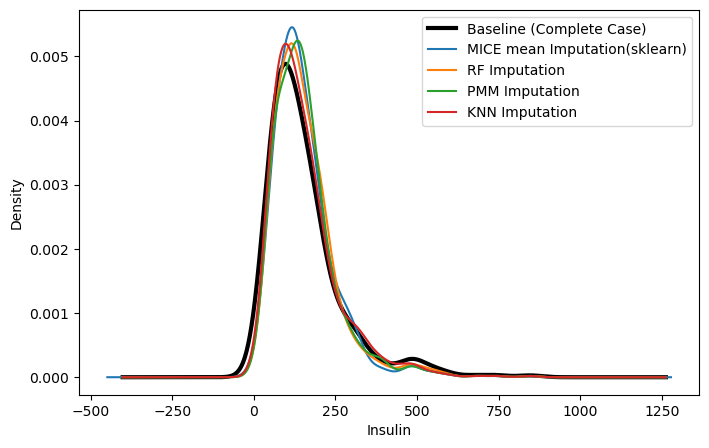

In [19]:
pima_cc = pima.dropna(how='any') # complete case

plt.figure(figsize=(8,5))

pima_cc['insulin'].plot(kind='kde', c='black', linewidth=3)
MICE_mean_sk_df['insulin'].plot(kind='kde')
RF_df['insulin'].plot(kind='kde')
PMM_df['insulin'].plot(kind='kde')
KNN_df['insulin'].plot(kind='kde')


labels = ['Baseline (Complete Case)','MICE mean Imputation(sklearn)','RF Imputation',
          'PMM Imputation','KNN Imputation']
plt.legend(labels,loc='upper right')
plt.xlabel('Insulin')

Text(0.5, 0, 'glucose')

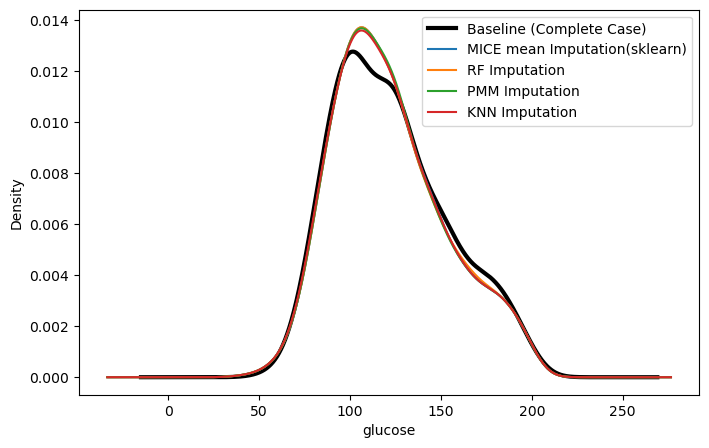

In [20]:
# for Glucose

plt.figure(figsize=(8,5))

pima_cc['glucose'].plot(kind='kde', c='black', linewidth=3)
MICE_mean_sk_df['glucose'].plot(kind='kde')
RF_df['glucose'].plot(kind='kde')
PMM_df['glucose'].plot(kind='kde')
KNN_df['glucose'].plot(kind='kde')

labels = ['Baseline (Complete Case)','MICE mean Imputation(sklearn)','RF Imputation',
          'PMM Imputation','KNN Imputation']
plt.legend(labels,loc='upper right')
plt.xlabel('glucose')

### Comparing insulin by correlation

In [21]:
# Select the 'insulin' columns from each DataFrame

insulin_pima = pima['insulin']
insulin_mice_mean_sk = MICE_mean_sk_df['insulin']
insulin_RF = RF_df['insulin']
insulin_PMM = PMM_df['insulin']
insulin_KNN = KNN_df['insulin']


# Create a DataFrame with all 'insulin' columns
data = pd.DataFrame({
    'pima_insu': insulin_pima,
    'mice_mean_sk_insu': insulin_mice_mean_sk,
    'RF_insu': insulin_RF,
    'PMM_insu': insulin_PMM,
    'KNN_insu': insulin_KNN
})

# Calculate the pairwise correlation
correlation_matrix = data.corr(method='pearson')

correlation_matrix

,pima_insu,mice_mean_sk_insu,RF_insu,PMM_insu,KNN_insu
pima_insu,1.0,1.000000,1.000000,1.000000,1.000000
mice_mean_sk_insu,1.0,1.000000,0.960700,0.953323,0.890599
RF_insu,1.0,0.960700,1.000000,0.948042,0.895541
PMM_insu,1.0,0.953323,0.948042,1.000000,0.901210
KNN_insu,1.0,0.890599,0.895541,0.901210,1.000000


Of course, all imputed data sets perfectly align with the original data set. 

###  2.3    Run a regression with the same model for each of the five data sets
Use the following model: glm(test ~ pregnant + diastolic + triceps + bmi + age + insulin, data=..., family=binomial). Compare coefficient estimates, e.g. as a bar plot.

In [22]:
# Define the formula for the logistic regression model
formula = 'test ~ pregnant + diastolic + triceps + bmi + age + insulin'

# Fit logistic regression model
fmraw = sm.GLM.from_formula(formula, data=pima, family=sm.families.Binomial()).fit()
fmmi = sm.GLM.from_formula(formula, data=imput_mi_one, family=sm.families.Binomial()).fit()
fmmice_mean_sk = sm.GLM.from_formula(formula, data=MICE_mean_sk_df, family=sm.families.Binomial()).fit()
fmRF = sm.GLM.from_formula(formula, data=RF_df, family=sm.families.Binomial()).fit()
fmPMM = sm.GLM.from_formula(formula, data=PMM_df, family=sm.families.Binomial()).fit()
fmKNN = sm.GLM.from_formula(formula, data=KNN_df, family=sm.families.Binomial()).fit()



## Compare coefficients

compare = pd.DataFrame({'Raw': fmraw.params,
                    'Imput_mi_one': fmmi.params,   
                   'MICE_mean (sk)': fmmice_mean_sk.params,
                   'RF': fmRF.params,                   
                   'PMM': fmPMM.params,
                   'KNN': fmKNN.params})

compare

,Raw,Imput_mi_one,MICE_mean (sk),RF,PMM,KNN
Intercept,-6.183266,-5.672342,-6.066438,-5.715485,-5.952500,-5.829312
pregnant,0.059344,0.098042,0.103731,0.117113,0.104200,0.105381
diastolic,0.003717,0.000398,-0.002373,-0.000422,-0.000704,0.001688
triceps,0.016433,0.009726,0.021419,0.011540,0.013254,0.016240
bmi,0.062838,0.088655,0.080515,0.083784,0.086218,0.081067
age,0.053732,0.022002,0.021481,0.015041,0.020880,0.020575
insulin,0.004105,0.003911,0.007175,0.006253,0.006137,0.004792


### Barplot of the coefficients

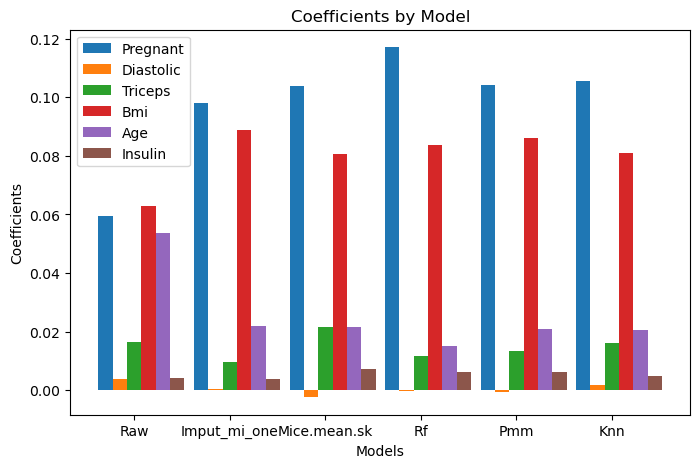

In [23]:
# Define the coefficients for each model without intercept
coef_fmraw =  list(fmraw.params[1:])
coef_fmmi = list(fmmi.params[1:])
coef_fmmsk = list(fmmice_mean_sk.params[1:])
coef_fmRF = list(fmRF.params[1:])
coef_fmPMM = list(fmPMM.params[1:])
coef_fmknn = list(fmKNN.params[1:])


# Combine the coefficients into a 2D array
coef_array = np.array([coef_fmraw, coef_fmmi, coef_fmmsk, coef_fmRF, coef_fmPMM, coef_fmknn])

# Define the models for the x-axis labels
models = ['Raw','Imput_mi_one','Mice.mean.sk', 'Rf','Pmm','Knn']

# Set the positions for the bars
x = np.arange(len(models))

plt.figure(figsize=(8,5))

# Define the width of the bars
width = 0.15

# Create the grouped bar plot
for i, coef in enumerate(coef_array.T):
    plt.bar(x + i*width, coef, width, label=f'coef_{i+1}')

# Define labels for the legend
legend_labels = ['Pregnant', 'Diastolic', 'Triceps', 'Bmi','Age', 'Insulin']

# Set labels and title
plt.xlabel('Models')
plt.ylabel('Coefficients')
plt.title('Coefficients by Model')
plt.xticks(x + 2*width, models)
plt.legend(legend_labels)

# Show the plot
plt.show()

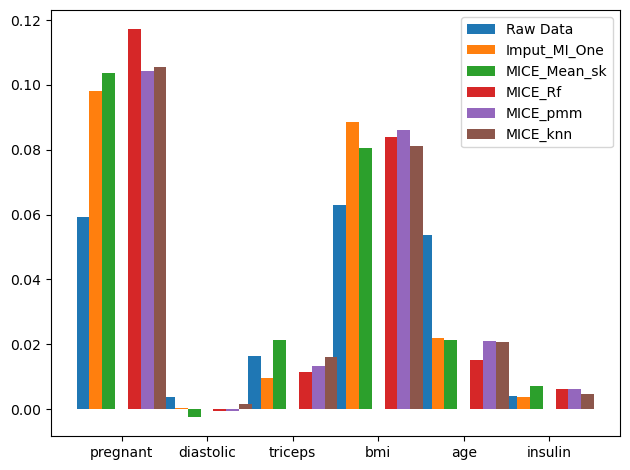

In [25]:
# Can also be plotted like this:

coef_fmraw =  list(fmraw.params[1:])
coef_fmmi = list(fmmi.params[1:])
coef_fmmsk = list(fmmice_mean_sk.params[1:])
coef_fmRF = list(fmRF.params[1:])
coef_fmPMM = list(fmPMM.params[1:])
coef_fmknn = list(fmKNN.params[1:])

# Can also be ploted like below:
labels = ['pregnant', 'diastolic', 'triceps', 'bmi', 'age', 'insulin']
x = np.arange(len(labels))
width = 0.15


fig, ax = plt.subplots()
ax.bar(x - width * 3, coef_fmraw, width, label='Raw Data')
ax.bar(x - width * 2, coef_fmmi, width, label='Imput_MI_One')
ax.bar(x - width , coef_fmmsk, width, label='MICE_Mean_sk')
ax.bar(x + width, coef_fmRF, width, label='MICE_Rf')
ax.bar(x + width * 2, coef_fmPMM, width, label='MICE_pmm')
ax.bar(x + width * 3, coef_fmknn, width, label='MICE_knn')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

The effects of imputation are consistent for predictors pregnant, bmi and age, but not for triceps and diastolic. 

# Exercise 3:   Quantify effect of imputation on model estimates
Run the GLM-analysis across 10 random-forest imputed data sets and quantify the effect of imputation on estimate variability (using `IterativeImputer(estimator=rf)`). 

In [26]:
# This is equivalent to running a GLM on 10 chains of Rf imputed datasets merged together as one dataframe

warnings.filterwarnings('ignore') # this is to surpress warining
#####################################################################

pima_subset = pima[['pregnant', 'diastolic', 'triceps', 'bmi','age','insulin']]
n_chains = 10
imputations = []

for _ in range(n_chains):
    imputer_rf = IterativeImputer(estimator=rf(n_estimators=100, max_depth=5), n_nearest_features=5)
    imputed_data = imputer_rf.fit_transform(pima_subset)
    imputations.append(pd.DataFrame(imputed_data, columns=pima_subset.columns))

    
### Now combine to have one Dataframe with mean
completed_datasets = [imputation.ffill().bfill() for imputation in imputations]
imput_rf_one = pd.concat(completed_datasets).groupby(level=0).mean()
imput_rf_one['test'] = pima['test']
imput_rf_one.describe()

,pregnant,diastolic,triceps,bmi,age,insulin,test
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,72.356956,28.821527,32.424180,33.240885,161.517410,0.348958
std,3.369578,12.166495,9.732166,6.887727,11.760232,97.744656,0.476951
min,0.000000,24.000000,7.000000,18.200000,21.000000,14.000000,0.000000
25%,1.000000,64.000000,22.000000,27.500000,24.000000,106.000000,0.000000
50%,3.000000,72.000000,28.000000,32.000000,29.000000,140.000000,0.000000
75%,6.000000,80.000000,35.250000,36.600000,41.000000,190.000000,1.000000
max,17.000000,122.000000,99.000000,67.100000,81.000000,846.000000,1.000000


In [27]:
# Now we can fit the GLM

formula = "test ~ pregnant + diastolic + triceps + bmi + age + insulin"

glm_fit = sm.GLM.from_formula(formula, imput_rf_one, family=sm.families.Binomial()).fit()
print(glm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   test   No. Observations:                  768
Model:                            GLM   Df Residuals:                      761
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -424.47
Date:                Mon, 18 Mar 2024   Deviance:                       848.94
Time:                        14:15:59   Pearson chi2:                     728.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1716
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.6728      0.644     -8.809      0.0

### A better way is to fit GLM in a `for-loop`, and pool the coefficients [We talked about this possibility in class]

In [28]:
# using RF still:
warnings.filterwarnings('ignore') # this is to surpress warining
##############################################

np.random.seed(123)
n_chains = 10
imputations = []

for _ in range(n_chains):
    imputer_rf = IterativeImputer(estimator=rf(n_estimators=100, max_depth=5), n_nearest_features=5)
    imputed_data = imputer_rf.fit_transform(pima_subset)
    imputed_data = pd.DataFrame(imputed_data, columns=pima_subset.columns) # as a DataFrame
    imputed_data['test'] = pima['test'] # adding the response variable to the dataset
    imputations.append(imputed_data)


# Perform the GLM on each imputed dataset
results = []

for imp in imputations:
    formula = "test ~ pregnant + diastolic + triceps + bmi + age + insulin"
    model = sm.GLM.from_formula(formula, imp, family=sm.families.Binomial())
    result = model.fit()
    results.append(result)

# Pool the results
pooled_coef_est = []
pooled_coef_se = []
for result in results:
    pooled_coef_est.append(result.params)
    pooled_coef_se.append(result.bse)

pooled_coef_est = pd.DataFrame(pooled_coef_est).mean()
pooled_coef_se = pd.DataFrame(pooled_coef_se).mean()

frames = [pooled_coef_est, pooled_coef_se]
pooled_coef_both = pd.concat(frames, axis=1)

new_columns = {0: 'Est', 1: 'Std.err'}
pooled_coef_both.rename(columns=new_columns, inplace=True)

# Display the pooled coefficients
print(pooled_coef_both)

                Est   Std.err
Intercept -5.669961  0.644543
pregnant   0.105016  0.028826
diastolic  0.001055  0.007818
triceps    0.008457  0.012084
bmi        0.093883  0.018420
age        0.020207  0.009240
insulin    0.002945  0.000957


**What about using the predictive mean matching (pmm) instead?**

In [30]:
# A better and faster way to do this is via MICEData from 'statsmodels.imputation.mice'
imp = MICEData(data=pima, perturbation_method='gaussian', k_pmm=2) 


# fit the GLM using the 10 imputations

formula='test ~ pregnant + diastolic + triceps + bmi + age + insulin'
mice = MICE(formula, sm.GLM, imp, init_kwds={"family": sm.families.Binomial()})
results = mice.fit(10, 10)  #fit([n_burnin, n_imputations])
print(results.summary())

                         Results: MICE
Method:                   MICE       Sample size:           768 
Model:                    GLM        Scale                  1.00
Dependent variable:       test       Num. imputations       10  
----------------------------------------------------------------
           Coef.  Std.Err.    t    P>|t|   [0.025  0.975]  FMI  
----------------------------------------------------------------
Intercept -5.7427   0.6632 -8.6598 0.0000 -7.0425 -4.4430 0.0427
pregnant   0.1056   0.0298  3.5487 0.0004  0.0473  0.1639 0.0375
diastolic  0.0004   0.0081  0.0496 0.9605 -0.0155  0.0163 0.0809
triceps    0.0122   0.0123  0.9927 0.3209 -0.0119  0.0364 0.2188
bmi        0.0840   0.0193  4.3498 0.0000  0.0461  0.1218 0.1852
age        0.0235   0.0091  2.5899 0.0096  0.0057  0.0412 0.0509
insulin    0.0046   0.0011  4.0014 0.0001  0.0023  0.0068 0.4778



Both triceps and the insulin effects are substantially affected by missingness, yet their error is still so low that the significance of these effects is unaffected.